# 2. Classification
*필요 library:
    seaborn, tensorflow, pytorch, torchvision, imbalanced-learn, einops
    
### 1) Getting data

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os, glob
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

In [6]:
#다시, 파일 모두 가져오기
import PIL
from PIL import Image
import torch
import torchvision
from torch.utils.data import  TensorDataset, DataLoader
import torchvision.transforms as transforms
from keras.preprocessing.image import img_to_array,array_to_img

PATH = './train/'

image_dirs = os.listdir(PATH)
image_paths = dict()
for image_dir in tqdm(image_dirs):
    try:
        files = glob.glob(PATH + image_dir+"/*.png") 
        image_paths[image_dir] = [file for file in files]
    except:
        FileNotFoundError

#image transform
transform = transforms.Compose([
    transforms.Resize([64,64]), #64으로 줄여서 진행.
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

labels = []
filenames = []
image_arr = []
for label,paths in tqdm(image_paths.items()):
    for path in paths:
        img = Image.open(path)
        img = img.convert('RGB')
        filenames.append(path)
        img_arr = img_to_array(transform(img)) #3,64,64
        image_arr.append(img_arr)
        labels.append(label)
        
df = pd.DataFrame()
df['label'] = labels
df['filename'] = filenames
df['image_arr'] = image_arr 

100%|██████████| 88/88 [03:28<00:00,  2.37s/it]


C:\Users\82109\anaconda3\envs\data\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


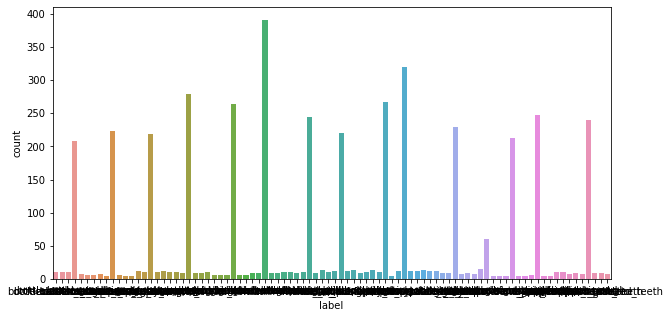

In [7]:
plt.figure(figsize=(10,5))
sns.countplot(df['label'])
plt.show()

In [8]:
#여러 이미지로 골고루 augmentation을 진행하다보니, label들이 정확히 같은 값으로 생성되지 않았음.
#down sampling을 진행.
label_count = Counter(df['label'])
max_label = max(label_count.values())

print(label_count)
print("minimum label:",min_label)

sampled_df = df.groupby('label').head(max_label)

Counter({'hazelnut-good': 391, 'screw-good': 320, 'carpet-good': 280, 'pill-good': 267, 'grid-good': 264, 'wood-good': 247, 'leather-good': 245, 'zipper-good': 240, 'tile-good': 230, 'cable-good': 224, 'metal_nut-good': 220, 'capsule-good': 219, 'transistor-good': 213, 'bottle-good': 209, 'toothbrush-good': 60, 'toothbrush-defective': 15, 'metal_nut-bent': 13, 'pill-color': 13, 'pill-crack': 13, 'screw-scratch_neck': 13, 'capsule-crack': 12, 'capsule-scratch': 12, 'metal_nut-flip': 12, 'metal_nut-scratch': 12, 'pill-scratch': 12, 'screw-manipulated_front': 12, 'screw-scratch_head': 12, 'screw-thread_side': 12, 'screw-thread_top': 12, 'bottle-broken_small': 11, 'bottle-contamination': 11, 'capsule-faulty_imprint': 11, 'capsule-poke': 11, 'metal_nut-color': 11, 'pill-contamination': 11, 'wood-scratch': 11, 'bottle-broken_large': 10, 'capsule-squeeze': 10, 'carpet-color': 10, 'carpet-thread': 10, 'leather-color': 10, 'leather-cut': 10, 'leather-glue': 10, 'pill-faulty_imprint': 10, 'zippe

C:\Users\82109\anaconda3\envs\data\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


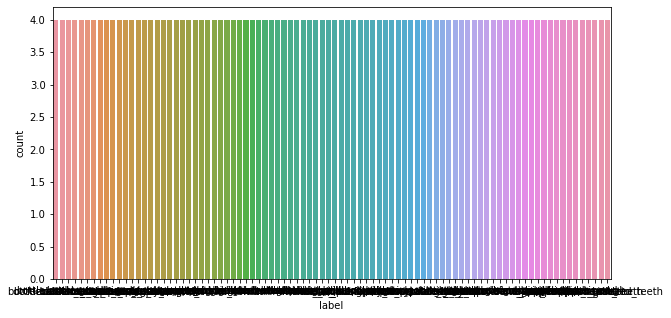

In [9]:
plt.figure(figsize=(10,5))
sns.countplot(sampled_df['label'])
plt.show()

### 2) Make Train/Valid/Test dataset

In [6]:
#train set, test set 분리
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(sampled_df['image_arr'], sampled_df['label'], 
                                                      test_size=0.3, 
                                                      shuffle=True, 
                                                      stratify=sampled_df['label'], #for balanced label.
                                                      random_state=1004)

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, 
                                                      test_size=0.3, 
                                                      shuffle=True, 
                                                      stratify=y_train, #for balanced label.
                                                      random_state=1004)

In [7]:
print("Training set:",len(x_train))
print("Validation set:",len(x_valid))
print("Test set:",len(x_test))

Training set: 539
Validation set: 231
Test set: 330


### 3) Training

#### CoAtNet - ImageNet SOTA

In [13]:
def make_img_tuple(X,Y):
    dataset = []
    for x,y in zip(X,Y):
        print(y)
        label = int(y[:1])
        y_int = np.zeros(10)
        y_int[label] = 1
        dataset.append((x,label))
    return dataset

train_images = make_img_tuple(x_train,y_train)
valid_images = make_img_tuple(x_valid,y_valid)
test_images = make_img_tuple(x_test,y_test)

4 RING
5 GUDEONGI
0 SPOT
4 RING
.ipynb_checkpoints


ValueError: invalid literal for int() with base 10: '.'

In [24]:
from torch.utils.data import  TensorDataset, DataLoader

dataloaders = {}
dataloaders['train'] = DataLoader(train_images, batch_size=16, shuffle=True)
dataloaders['valid'] = DataLoader(valid_images, batch_size=16, shuffle=True)
dataloaders['test'] = DataLoader(test_images, batch_size=16, shuffle=True)

In [25]:
#Model 설정
import torch.nn as nn
import Coatnet_3block
from Coatnet_3block import CoAtNet
#model is too big - made model only with 3 blocks

num_blocks = [2, 2, 3]            # number of blocks.
channels = [16, 48, 96]      # hidden dimension
block_types=['C', 'C', 'T']        # 'C' for MBConv, 'T' for Transformer
#in paper - with small dataset, CCTT works well.
#CoAtNet: Marrying Convolution and Attention for All Data Sizes

model = CoAtNet((64,64), 3, num_blocks, channels, num_classes = 10) 

In [26]:
#Loss function과 optimizer 설정

#Focal loss, Cross Entropy loss로 진행해 볼 것.
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.0001,
    betas=(0.9, 0.999),
    eps=10e-8,
    amsgrad=False,
)

display(model)

CoAtNet(
  (s0): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU()
    )
    (1): Sequential(
      (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU()
    )
  )
  (s1): Sequential(
    (0): MBConv(
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (proj): Conv2d(16, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (conv): PreNorm(
        (norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (fn): Sequential(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [27]:
# 평가 metrics 설정

def div(i1, i2):
    return i1/i2 if i2 else 0

def get_metrics(P,N):
    total = P+N
    acc = div(P,total)
    misclassficiation = div(N,total)
    return acc, misclassficiation

In [29]:
#Train
train = {'loss':[]}
valid = {'loss':[],'accuracy':[],'misclassification':[]}
test = {'loss':[],'accuracy':[],'misclassification':[]}

epochs = 20 
total_batches = len(dataloaders["train"])

for eid in range(epochs):
    print("Epoch {}".format(eid))
    loss_avg = 0
    for i, (inputs, targets) in enumerate(dataloaders["train"]):
        model.train()
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss_avg += loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()   
    train['loss'].append(loss_avg/total_batches)
    print("Training loss: {}".format(loss_avg/total_batches))
    # Validate model
    model.eval()
    with torch.no_grad():
        correct=0
        total = 0
        loss_avg = 0
        for i, (inputs, targets) in enumerate(dataloaders["valid"]):
            outputs = model(inputs)
            loss_avg += loss_fn(outputs, targets)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
        acc = correct/total
        valid['accuracy'].append(acc) 
        valid['misclassification'].append(1-acc) 
        valid['loss'].append(loss_avg/total_batches) 
        print("Validation loss: {}".format(loss_avg/total_batches))
        print("Validation accuracy: {}".format(acc))

Epoch 0
Training loss: 1.1670877933502197
Validation loss: 0.4293411374092102
Validation accuracy: 0.6637630662020906
Epoch 1
Training loss: 0.9622880816459656
Validation loss: 0.3672146797180176
Validation accuracy: 0.7077526132404182
Epoch 2
Training loss: 0.8348703980445862
Validation loss: 0.3527032732963562
Validation accuracy: 0.7277874564459931
Epoch 3
Training loss: 0.7495057582855225
Validation loss: 0.3168240487575531
Validation accuracy: 0.7552264808362369
Epoch 4
Training loss: 0.6858824491500854
Validation loss: 0.3052554130554199
Validation accuracy: 0.7626306620209059
Epoch 5
Training loss: 0.6201018691062927
Validation loss: 0.2953939437866211
Validation accuracy: 0.7709059233449478
Epoch 6
Training loss: 0.5614365339279175
Validation loss: 0.28561899065971375
Validation accuracy: 0.7774390243902439
Epoch 7
Training loss: 0.5150355696678162
Validation loss: 0.28270941972732544
Validation accuracy: 0.7804878048780488
Epoch 8
Training loss: 0.4660727083683014
Validation l

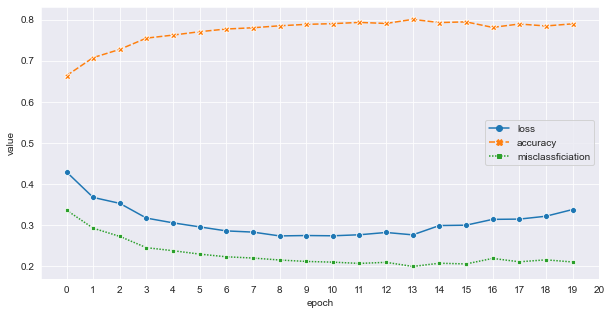

In [64]:
#Validation 결과 확인
plt.figure(figsize=(10,5))
valid['loss'] = list(np.array(valid['loss']))
sns.set_style("darkgrid")
sns.lineplot(markers=True,data=valid)
plt.grid(True)
plt.xlabel('epoch')
plt.ylabel('value')
plt.xticks([x for x in range(0,21)])
plt.show()

In [30]:
torch.save(model.state_dict(), "coatnet_CCT_epoch20.pth")

### 4) Test

In [139]:
acc = 0
misclassification = 0
test_inputs = []
test_targets= []
test_predicted = []
with torch.no_grad():
    correct=0
    total = 0
    for i, (inputs, targets) in enumerate(dataloaders["test"]):
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        test_predicted+=predicted
        test_inputs+=inputs
        test_targets+=targets
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
    acc = correct/total
    misclassification = 1-acc
    #Test 결과 확인
    print("Test accuracy: {}".format(round(acc,10)))
    print("Test misclassification: {}".format(round(misclassification,10)))

Test accuracy: 0.7926197011
Test misclassification: 0.2073802989


## 3. Export results

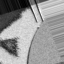

Reallabel: 9
Predicted: 9


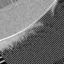

Reallabel: 9
Predicted: 9


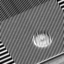

Reallabel: 5
Predicted: 5


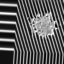

Reallabel: 1
Predicted: 1


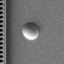

Reallabel: 0
Predicted: 0


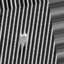

Reallabel: 1
Predicted: 8


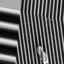

Reallabel: 1
Predicted: 8


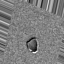

Reallabel: 6
Predicted: 6


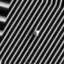

Reallabel: 2
Predicted: 8


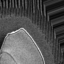

Reallabel: 3
Predicted: 9


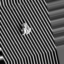

Reallabel: 1
Predicted: 1


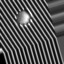

Reallabel: 4
Predicted: 1


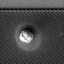

Reallabel: 4
Predicted: 4


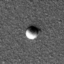

Reallabel: 0
Predicted: 0


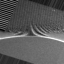

Reallabel: 9
Predicted: 9


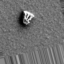

Reallabel: 2
Predicted: 7


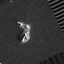

Reallabel: 1
Predicted: 1


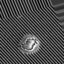

Reallabel: 4
Predicted: 4


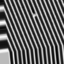

Reallabel: 8
Predicted: 8


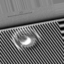

Reallabel: 5
Predicted: 5


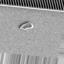

Reallabel: 6
Predicted: 6


In [149]:
#show images

test_predicted = [x.item() for x in test_predicted]
test_targets = [x.item() for x in test_targets]

idx=0
for predicts, inputs, targets in zip(test_predicted,test_inputs,test_targets):
    display(array_to_img(np.transpose(inputs, (2,1,0))))
    print("Reallabel:",targets)
    print("Predicted:",predicts)
    idx+=1
    if idx > 20:
        break